In [17]:
import os
import mmcv
from mmcv import Config

from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import single_gpu_test

from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel

import pandas as pd
import numpy as np
import json
import torch
from tqdm import tqdm

# Ensemble
## define function get logit values

In [5]:
def get_model_logit(config_path, model_path):

    cfg = Config.fromfile(config_path)
    root = 'images/test/'

    cfg.data.test.img_dir = root
    cfg.data.test.pipeline[1]['img_scale'] = (512,512)
    cfg.data.test.test_mode = True


    cfg.work_dir = '/opt/ml/lab/mmsegmentation/work_dirs'

    cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
    cfg.model.train_cfg = None

    #define dataset
    dataset = build_dataset(cfg.data.test)
    data_loader = build_dataloader(
            dataset,
            samples_per_gpu=1,
            workers_per_gpu=cfg.data.workers_per_gpu,
            dist=False,
            shuffle=False)

    # build model architecture
    model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
    checkpoint = load_checkpoint(model, model_path, map_location='cpu')
    
    model.CLASSES = dataset.CLASSES
    model = MMDataParallel(model.cuda(), device_ids=[0])
    
    print(f'{model_path} is ready to run')
    return single_gpu_test(model, data_loader)

In [6]:
config_path = '/opt/ml/lab/config_file/upernet_swin.py'
model_path = '/opt/ml/lab/mmsegmentation/pretrained'
output_1 = get_model_logit(config_path, model_path+'/swin_fold1.pth')
output_2 = get_model_logit(config_path, model_path+'/swin_plain_Fold_2.pth')
output_3 = get_model_logit(config_path, model_path+'/swin_plain_Fold_3.pth')
output_4 = get_model_logit(config_path, model_path+'/swin_plain_Fold_4.pth')
output_5 = get_model_logit(config_path, model_path+'/swin_plain_Fold_5.pth')


2021-11-01 13:43:19,454 - mmseg - INFO - Loaded 819 images


Use load_from_local loader
/opt/ml/lab/mmsegmentation/pretrained/swin_fold1.pth is ready to run
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 5.4 task/s, elapsed: 151s, ETA:     0s

2021-11-01 13:45:56,300 - mmseg - INFO - Loaded 819 images


Use load_from_local loader
/opt/ml/lab/mmsegmentation/pretrained/swin_plain_Fold_2.pth is ready to run
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 5.4 task/s, elapsed: 151s, ETA:     0s

2021-11-01 13:48:30,437 - mmseg - INFO - Loaded 819 images


Use load_from_local loader
/opt/ml/lab/mmsegmentation/pretrained/swin_plain_Fold_3.pth is ready to run
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 4.5 task/s, elapsed: 181s, ETA:     0s

2021-11-01 13:51:34,235 - mmseg - INFO - Loaded 819 images


Use load_from_local loader
/opt/ml/lab/mmsegmentation/pretrained/swin_plain_Fold_4.pth is ready to run
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 4.5 task/s, elapsed: 182s, ETA:     0s

2021-11-01 13:54:39,138 - mmseg - INFO - Loaded 819 images


Use load_from_local loader
/opt/ml/lab/mmsegmentation/pretrained/swin_plain_Fold_5.pth is ready to run
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 4.5 task/s, elapsed: 182s, ETA:     0s

### ensemble start
- result = sum(output_1, output_2)
- argmax(result, axis=0)

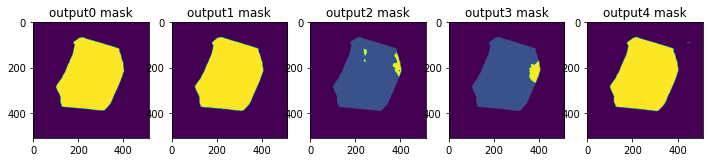

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# mask = np.where(mask==0, 255, mask)

predict_mask_array = []
    
predict_mask_array.append(output_1[470].argmax(axis=0))
predict_mask_array.append(output_2[470].argmax(axis=0))
predict_mask_array.append(output_3[470].argmax(axis=0))
predict_mask_array.append(output_4[470].argmax(axis=0))
predict_mask_array.append(output_5[470].argmax(axis=0))

for i in range(5):
    ax[i].set_title(f'output{i} mask')
    ax[i].imshow(predict_mask_array[i])

plt.show()

In [15]:
def cal_class_counts(value):
    classes, counts = np.unique(value, return_counts=True)
    for i,v in zip(classes, counts):
        print(i,v)
        
for item in predict_mask_array:
    cal_class_counts(item)

0 249767
1 12377
0 249895
1 5280
6 6969
0 249487
1 12657
0 249851
1 12293
0 249489
1 12655


In [18]:
output_to_mask = []

for item_1, item_2, item_3, item_4, item_5 in tqdm(zip(output_1, output_2, output_3, output_4, output_5)):
    
    new_item = item_1 + item_2 + item_3 + item_4 + item_5
    output_to_mask.append(new_item.argmax(axis=0))

819it [00:13, 58.84it/s]


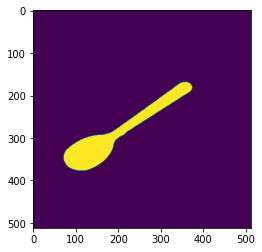

In [20]:
plt.imshow(output_to_mask[2])
classes, counts = np.unique(output_to_mask[2], return_counts=True)

In [21]:
cal_class_counts(output_to_mask[0])

0 209065
8 53079


In [23]:
# sample_submisson.csv 열기
submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)
json_dir = os.path.join("/opt/ml/segmentation/input/data/test.json") # original json file
save_dir = '/opt/ml/lab/config_file/work_dirs/upernet_swin'
with open(json_dir, "r", encoding="utf8") as outfile:
    datas = json.load(outfile)

input_size = 512
output_size = 256
bin_size = input_size // output_size

# PredictionString 대입
for image_id, predict in enumerate(output_to_mask):
    image_id = datas["images"][image_id]
    file_name = image_id["file_name"]
    
    temp_mask = []
    predict = predict.reshape(1, 512, 512)
    mask = predict.reshape((1, output_size, bin_size, output_size, bin_size)).max(4).max(2) # resize to 256*256
    temp_mask.append(mask)
    oms = np.array(temp_mask)
    oms = oms.reshape([oms.shape[0], output_size*output_size]).astype(int)

    string = oms.flatten()

    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(os.path.join(save_dir, f'submission_ensemble.csv'), index=False)

In [21]:
print(cfg.work_dir)

/opt/ml/lab/mmsegmentation/work_dirs


In [22]:
print(cfg.data.test)

{'type': 'COCOTrashDataset', 'data_root': '/opt/ml/lab/mmsegmentation/fold_dataset', 'img_dir': 'images/test/', 'ann_dir': '/opt/ml/lab/mmsegmentation/fold_dataset/annotations/test', 'classes': ('Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing'), 'pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'MultiScaleFlipAug', 'img_scale': (512, 512), 'img_ratios': [0.75, 1.0, 1.25], 'flip': False, 'transforms': [{'type': 'Resize', 'keep_ratio': True}, {'type': 'RandomFlip', 'prob': 0.5, 'direction': 'horizontal'}, {'type': 'Normalize', 'mean': [117.324, 112.09, 106.66], 'std': [53.76, 52.95, 55.22], 'to_rgb': True}, {'type': 'ImageToTensor', 'keys': ['img']}, {'type': 'Collect', 'keys': ['img']}]}], 'test_mode': True}


In [25]:
import pickle

pickle_list = []

for item_1, item_2, item_3, item_4, item_5 in tqdm(zip(output_1, output_2, output_3, output_4, output_5)):
    
    new_item = item_1 + item_2 + item_3 + item_4 + item_5
    pickle_list.append(new_item)
    
with open('swin_fold_ensemble.bin', 'wb') as f:
    pickle.dump(pickle_list , f)

819it [00:28, 29.10it/s]


In [26]:
with open('swin_fold_ensemble.bin' ,'rb') as ff:
    data = pickle.load(ff)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [30]:
print(np.array(data).shape)

(819, 11, 512, 512)
